# Case Study: Bring Your Own Data

Do you have a dataset that needs to be gap-filled?  

In this notebook we repeat the analysis for user supplied data.

# Download and prepare the dataset

::: {note}
The section will be dependent on your own data set. You need to wrangle your data into a single file stored as a `.csv` similar to `dataset.csv`. 

The first column should be a date or timestamp field.

The remaining columns are numerical values for physical measurements. The multivariable imputation methods KNN, MICE, and MissForest are applicable when you have multiple dependent variables taken the the same time. 
:::

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
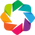

In [2]:
from erddapy import ERDDAP
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import panel as pn
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
pn.extension()

In [3]:
df = pd.read_csv('dataset.csv', parse_dates=True, index_col=0)

In [4]:
df

,BlueIsland_2m,BlueIsland_5m,BlueIsland_10m,Ingomar_2m,Ingomar_5m,Ingomar_10m,Ingomar_15m,McNuttsIsland_2m,McNuttsIsland_5m,McNuttsIsland_10m,McNuttsIsland_15m,McNuttsIsland_20m,TaylorsRock_2m,TaylorsRock_5m,TaylorsRock_10m,TaylorsRock_15m,TaylorsRock_20m
date,,,,,,,,,,,,,,,,,
2018-05-15,8.634,7.762,6.811,7.664,6.993,6.220,5.637,6.504,6.295,5.991,5.737,4.492,7.141,6.778,6.217,5.922,5.871
2018-05-16,9.009,7.564,6.215,7.347,6.636,5.912,5.390,7.222,6.786,6.184,5.737,4.420,6.980,6.595,6.050,5.732,5.449
2018-05-17,8.074,7.188,6.466,7.621,7.072,6.544,6.034,7.828,7.398,6.245,5.606,4.322,7.346,6.994,6.574,6.328,6.092
2018-05-18,8.441,7.328,6.099,7.993,7.554,7.025,6.501,8.065,7.444,6.599,5.952,4.644,7.312,7.033,6.523,6.207,5.757
2018-05-19,7.649,6.877,6.142,8.180,7.809,7.421,6.901,7.883,7.127,5.962,5.392,4.141,7.667,7.398,7.056,6.856,6.507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10,6.555,6.554,6.692,6.617,6.709,6.589,5.733,NaN,NaN,6.604,6.651,6.642,6.400,NaN,6.358,6.396,6.521
2022-05-11,6.754,6.753,6.837,6.816,6.895,6.738,5.896,NaN,NaN,6.720,6.667,6.529,6.442,NaN,6.393,6.424,6.525
2022-05-12,7.026,6.947,7.000,6.809,6.761,6.466,5.617,NaN,NaN,6.645,6.217,6.000,6.523,NaN,6.252,6.139,6.142


## Explore the data

In [5]:
def plot_all_sites(df, cmap='Viridis'):
    image_data = df.astype('float32').T.values
    
    x_labels = df.index.strftime('%Y-%m-%d')  # dates → x-axis
    y_labels = list(df.columns)               # station-depths → y-axis
    
    x_coords = np.arange(len(x_labels))
    y_coords = np.arange(len(y_labels))
    
    heatmap = hv.Image((x_coords, y_coords, image_data)).opts(
        xaxis='bottom',
        xlabel='Date',
        ylabel='Station @ Depth',
        xticks=list(zip(x_coords[::30], x_labels[::30])),  # every 30th date
        yticks=list(zip(y_coords, y_labels)),
        xrotation=45,
        cmap=cmap,
        colorbar=True,
        width=1000,
        height=800,
        tools=['hover']
    )
    return heatmap
    
plot_all_sites(df)

:Image   [x,y]   (z)

### Visualize the series data

In [11]:
# Create a dropdown selector
site_selector = pn.widgets.Select(name='Site', options=list(df.columns))

def highlight_nan_regions(label):

    series = df[label]
    
    # Identify NaN regions
    is_nan = series.isna()
    nan_ranges = []
    current_start = None

    for date, missing in is_nan.items():
        if missing and current_start is None:
            current_start = date
        elif not missing and current_start is not None:
            nan_ranges.append((current_start, date))
            current_start = None
    if current_start is not None:
        nan_ranges.append((current_start, series.index[-1]))

    # Create shaded regions
    spans = [
        hv.VSpan(start, end).opts(color='red', alpha=0.2)
        for start, end in nan_ranges
    ]

    curve = hv.Curve(series, label=label).opts(
        width=900, height=250, tools=['hover', 'box_zoom', 'pan', 'wheel_zoom'],
        show_grid=True, title=label
    )

    return curve * hv.Overlay(spans)
    
interactive_plot = hv.DynamicMap(pn.bind(highlight_nan_regions, site_selector))

pn.Column(site_selector, interactive_plot, 'Hightlights regions are gaps that need to imputed.')

Column
    [0] Select(name='Site', options=['BlueIsland_2m', ...], value='BlueIsland_2m')
    [1] HoloViews(DynamicMap, height=250, sizing_mode='fixed', width=900)
    [2] Markdown(str)

## Impute the gaps

We have determined that the `MissForest`appears to work reasonably well when imputing artificially large gaps. 

We use it to gap fill the missing data in this dataset.

In [12]:
from imputeMF import imputeMF

In [13]:
df_imputed = pd.DataFrame(imputeMF(df.values, 10, print_stats=True), columns=df.columns, index=df.index)

Statistics:
iteration 1, gamma = 0.03431894409323924
Statistics:
iteration 2, gamma = 0.0005762632212411448
Statistics:
iteration 3, gamma = 8.236875752282678e-05
Statistics:
iteration 4, gamma = 2.5255770971817778e-05
Statistics:
iteration 5, gamma = 1.3630642714695858e-05
Statistics:
iteration 6, gamma = 1.1119706955897746e-05
Statistics:
iteration 7, gamma = 9.008172512535662e-06
Statistics:
iteration 8, gamma = 8.351600838941382e-06
Statistics:
iteration 9, gamma = 7.730331223170641e-06
Statistics:
iteration 10, gamma = 7.148441593724086e-06


In [14]:
df_imputed

,BlueIsland_2m,BlueIsland_5m,BlueIsland_10m,Ingomar_2m,Ingomar_5m,Ingomar_10m,Ingomar_15m,McNuttsIsland_2m,McNuttsIsland_5m,McNuttsIsland_10m,McNuttsIsland_15m,McNuttsIsland_20m,TaylorsRock_2m,TaylorsRock_5m,TaylorsRock_10m,TaylorsRock_15m,TaylorsRock_20m
date,,,,,,,,,,,,,,,,,
2018-05-15,8.634,7.76200,6.811,7.66400,6.99300,6.220,5.637,6.50400,6.29500,5.991,5.737,4.492,7.141,6.77800,6.217,5.922,5.871
2018-05-16,9.009,7.56400,6.215,7.34700,6.63600,5.912,5.390,7.22200,6.78600,6.184,5.737,4.420,6.980,6.59500,6.050,5.732,5.449
2018-05-17,8.074,7.18800,6.466,7.62100,7.07200,6.544,6.034,7.82800,7.39800,6.245,5.606,4.322,7.346,6.99400,6.574,6.328,6.092
2018-05-18,8.441,7.32800,6.099,7.99300,7.55400,7.025,6.501,8.06500,7.44400,6.599,5.952,4.644,7.312,7.03300,6.523,6.207,5.757
2018-05-19,7.649,6.87700,6.142,8.18000,7.80900,7.421,6.901,7.88300,7.12700,5.962,5.392,4.141,7.667,7.39800,7.056,6.856,6.507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10,6.555,6.55400,6.692,6.61700,6.70900,6.589,5.733,6.58291,6.61944,6.604,6.651,6.642,6.400,6.43280,6.358,6.396,6.521
2022-05-11,6.754,6.75300,6.837,6.81600,6.89500,6.738,5.896,6.67078,6.70837,6.720,6.667,6.529,6.442,6.56042,6.393,6.424,6.525
2022-05-12,7.026,6.94700,7.000,6.80900,6.76100,6.466,5.617,6.65660,6.60378,6.645,6.217,6.000,6.523,6.63074,6.252,6.139,6.142


In [15]:
def highlight_imputed_regions(label):

    series = df[label]
    series_imputed = df_imputed[label]
    
    # Identify NaN regions
    is_nan = series.isna()
    nan_ranges = []
    current_start = None

    for date, missing in is_nan.items():
        if missing and current_start is None:
            current_start = date
        elif not missing and current_start is not None:
            nan_ranges.append((current_start, date))
            current_start = None
    if current_start is not None:
        nan_ranges.append((current_start, series.index[-1]))

    # Create shaded regions
    spans = [
        hv.VSpan(start, end).opts(color='red', alpha=0.2)
        for start, end in nan_ranges
    ]

    curve = hv.Curve(series_imputed, label=label).opts(
        width=900, height=250, tools=['hover', 'box_zoom', 'pan', 'wheel_zoom'],
        show_grid=True, title=label
    )

    return curve * hv.Overlay(spans)
    
interactive_plot = hv.DynamicMap(pn.bind(highlight_imputed_regions, site_selector))

pn.Column(site_selector, interactive_plot)

Column
    [0] Select(name='Site', options=['BlueIsland_2m', ...], value='BlueIsland_2m')
    [1] HoloViews(DynamicMap, height=250, sizing_mode='fixed', width=900)

Highlighted regions show where the gaps have been imputed.

Notice the imputation algorithm gap fills in time intervals where there is very limited information from any other site. Care should be taken in interpretation of interpolated data.

In [16]:
plot_all_sites(df_imputed)

:Image   [x,y]   (z)

```{warning}
Apply caution when using these imputed datasets in subsequent analysis steps.  While the imputed regions appears reasonable, they are not true measurements.  
```